In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('sampled_data_25k.csv')

df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour
0,2019-11-01 16:29:07+00:00,view,2500962,2053013564003713919,appliances.kitchen.oven,electrolux,463.20,516216750,026c0439-7540-4963-aba7-e753bd2a4ad3,16
1,2019-11-02 13:26:31+00:00,view,9600155,2053013561185141473,NaN,dji,468.19,512783488,080c2e91-e335-4a89-a889-0a5a619f9051,13
2,2019-11-01 17:49:29+00:00,view,14700670,2053013557133443581,furniture.living_room.cabinet,sv,123.53,513741357,a7685abc-71cf-45b3-9870-d344847fba0f,17
3,2019-11-01 14:50:45+00:00,view,3600145,2053013563810775923,appliances.kitchen.washer,indesit,169.63,530256322,a5ed5609-800d-4e95-a631-dd86d2da2b98,14
4,2019-11-02 08:18:23+00:00,view,18000258,2053013558525952589,NaN,samsung,6.41,512777444,ae2564fd-5166-4216-8914-77b16b0bae45,8


In [ ]:
#verificar cantidad de valores nulos

nulos = df.isnull().sum()
print('la cantidad de valores nulos es de:\n',nulos)

#verificar cantidad de valores duplicados

duplicados = df.duplicated().sum()
print('la cantidad de valores duplicados es de: ',duplicados)

la cantidad de valores nulos es de:
 event_time          0
event_type          0
product_id          0
category_id         0
category_code    8116
brand            3665
price               0
user_id             0
user_session        0
hour                0
dtype: int64
la cantidad de valores duplicados es de:  0


In [ ]:
# Rellenar los nulos en 'category_code' y 'brand' con 'desconocido'
df['category_code'].fillna('desconocido', inplace=True)
df['brand'].fillna('desconocido', inplace=True)

# Verificar los cambios
print(df.isnull().sum())

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
hour             0
dtype: int64


<ipython-input-4-7776cfcf62e4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna('desconocido', inplace=True)
<ipython-input-4-7776cfcf62e4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

# Modelo SVM

In [ ]:
#Importar librerías
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve


In [ ]:
#Revisar la distribución de la variable objetivo

df['event_type'].unique()


array(['view', 'cart', 'purchase'], dtype=object)

In [ ]:
#Transformar la variable a binario
df['event_type'] = df['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

#Realizar One Hot encoding para variables categoricas
df = pd.get_dummies(df, columns=['brand', 'category_code'], drop_first=True)

#Normalización de la variable 'price'
scaler = StandardScaler()
df['price'] = scaler.fit_transform(df[['price']])

#Quitar columnas innecesarias
df = df.drop(columns=['event_time', 'product_id', 'category_id', 'user_id', 'user_session', 'hour'])

In [ ]:
#Observar la distribución de la variable

df['event_type'].value_counts()

,count
event_type,
0,24645
1,355


In [ ]:
#Realizar sobre muestreo

#Separar características y variable objetivo
X = df.drop(columns=['event_type'])
y = df['event_type']

# Aplicar SMOTE para balancear el conjunto de datos
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Comprobar la nueva distribución de 'event_type' después de SMOTE
print(y_resampled.value_counts())

event_type
0    24645
1    24645
Name: count, dtype: int64


In [ ]:
#Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [ ]:
#Inicializar y entrenar el modelo SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)


SVC()

In [ ]:
#Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

#Mostrar el reporte de clasificación y la matriz de confusión
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.72      0.79      7381
           1       0.76      0.90      0.83      7406

    accuracy                           0.81     14787
   macro avg       0.82      0.81      0.81     14787
weighted avg       0.82      0.81      0.81     14787

[[5322 2059]
 [ 757 6649]]


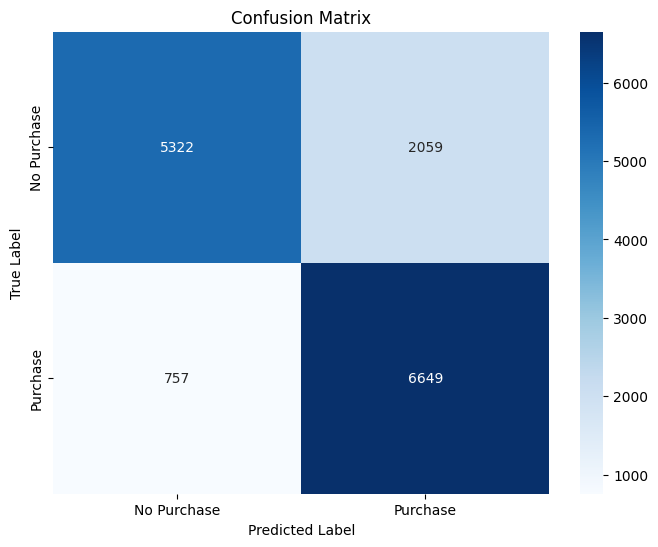

In [ ]:
#Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

#Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


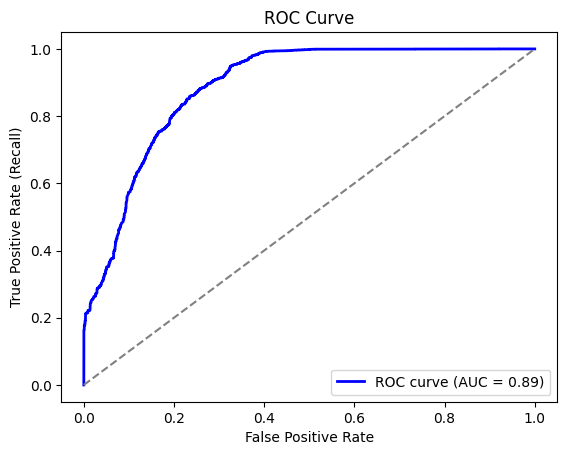

In [ ]:
#Obtener las probabilidades de predicción para la clase positiva
y_scores = svm_model.decision_function(X_test)

#Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea aleatoria
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


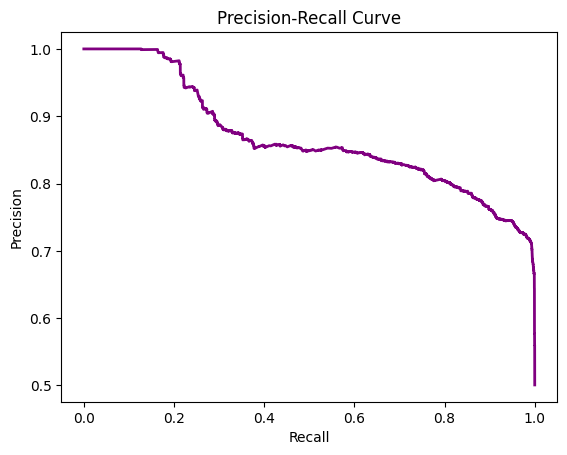

In [ ]:
#Calcular la curva de Precisión-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

#Graficar la curva
plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()
